In [1]:
import torch
import os
import random
import numpy as np


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


def set_seed(seed: int, workers: bool = False):
    seed = int(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms(False)

set_seed(42)

In [2]:
import math
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn, optim, distributions
from tqdm import tqdm
from pyro import distributions as dist
from pyro.distributions import transforms as T

In [3]:
exp_transform = T.ExpTransform()
log_transform = T.ExpTransform().inv

logit_transform = T.SigmoidTransform().inv
sigmoid_transform = T.SigmoidTransform()

In [4]:
M_RNG = (0.2, 100)
Q_RNG = (0.01, 0.99)
Z_RNG = (0.1, 3)
CHI_RNG = (-1, 1)


class DataLoader:
    batches = None

    def __init__(self, data, batch_size, shuffle=True):

        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.data_length = len(self.data)

    def __iter__(self):

        indices = list(reversed(range(0, self.data_length)))
        if self.shuffle:
            random.shuffle(indices)

        self.batches = [
            indices[i : i + self.batch_size]
            for i in range(0, self.data_length, self.batch_size)
        ]
        return self

    def __next__(self):
        if len(self.batches) > 0:
            return self.data[self.batches.pop()]
        raise StopIteration

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)


class TensorDataset:
    def __init__(self, tensor):
        self.tensor = tensor
        self.len = len(tensor)

    def __getitem__(self, index):
        return self.tensor[index]

    def __len__(self):
        return self.len


class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets
        self.len = max(len(d) for d in self.datasets)
        super().__init__()

    def __getitem__(self, index):
        if isinstance(index, slice):
            index = list(range(*index.indices(len(self))))
        index = torch.tensor(index)
        return torch.stack([d[index % len(d)] for d in self.datasets], dim=1)

    def __len__(self):
        return self.len

    def __len__(self):
        return self.len


class ConcatDataLoader:
    iterable = None

    def __init__(self, *dataloaders):
        self.dataloaders = dataloaders

        i, max_size = None, 0
        for j, loader in enumerate(self.dataloaders):
            length = len(loader)
            if len(loader) > max_size:
                i, max_size = j, length
        self.i = i
        self.max_size = max_size

    def __iter__(self):

        loaders = [
            loader if j == self.i else cycle(loader)
            for j, loader in enumerate(self.dataloaders)
        ]
        self.iterable = iter(zip(*loaders))
        return self

    def __next__(self):
        return next(self.iterable)

    def __len__(self):
        return self.max_size


def process_gw_data(path, normalize_fn=None):
    events = np.load(path, allow_pickle=True)
    datasets = []
    m1min, m1max = float("inf"), -float("inf")
    m2min, m2max = float("inf"), -float("inf")
    zmin, zmax = float("inf"), -float("inf")

    chimin, chimax = float("inf"), -float("inf")
    for n, event in events.items():
        m1 = torch.from_numpy(event["m1"])
        m1 = m1.clamp(*M_RNG)
        m1min = min(m1min, m1.min())
        m1max = max(m1max, m1.max())
#         m1 = log_transform(m1)
      
        m2 = torch.from_numpy(event["m2"])
        m2 = m2.clamp(*M_RNG)
        m2min = min(m2min, m2.min())
        m2max = max(m2max, m2.max())
#         m2 = log_transform(m2)

        
        z = torch.from_numpy(event["z"])
        z = z.clamp(*Z_RNG)
        zmin = min(zmin, z.min())
        zmax = max(zmax, z.max())

        chi = torch.from_numpy(event["Xeff"])
        chi = chi.clamp(*CHI_RNG)
        chimin = min(chimin, chi.min())
        chimax = max(chimax, chi.max())

        z_prior = torch.from_numpy(event["z_prior"])
        chi_prior = torch.from_numpy(event["Xeff_priors"])

        gw_data = torch.stack([m1, m2, chi, z, chi_prior, z_prior], dim=-1).float()

        datasets.append(TensorDataset(gw_data))

    dataset = ConcatDataset(*datasets)

    return dataset

In [5]:
dataset = process_gw_data('../../datasets/sampleDict_FAR_1_in_1_yr.pickle')
len(dataset)

268806

In [6]:
samples = dataset[torch.randint(0, len(dataset), (4096,))]

/tmp/ipykernel_2608933/825069406.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  index = torch.tensor(index)


In [7]:
DIM = 4
DEVICE = 'cuda'

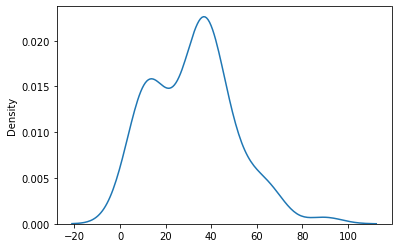

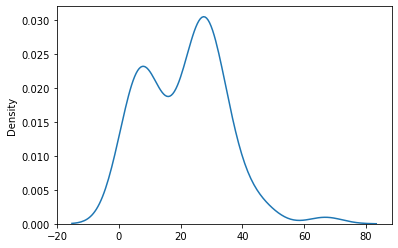

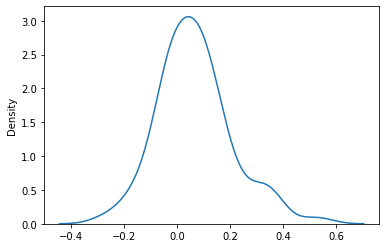

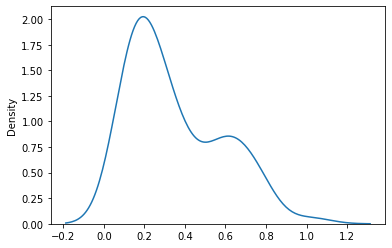

In [8]:
for i in range(DIM):
    sns.kdeplot(samples.mean(0)[:, i])
    plt.show()

In [9]:
# Per iteration, we use 2 posterior samples. Few samples leave more noise in the data, resulting in less sharp
# peaks in the final learned densities. More samples result in peakier (usually less physically plausible)
# learned densities. Using only 1 sample usually leaves too much noise to capture high frequency 
# characteristics.
dataloader = DataLoader(dataset, 2, shuffle=True)



In [10]:
base_dist = dist.Normal(torch.zeros(DIM, device=DEVICE), torch.ones(DIM, device=DEVICE))
transform = [T.block_autoregressive(DIM, hidden_factors=(2, 2), activation='tanh') for _ in range(1)]
composed_transform = T.ComposeTransformModule(transform).to(DEVICE)

transformed_dist = dist.TransformedDistribution(base_dist, composed_transform.inv)
optimizer = torch.optim.Adam(composed_transform.parameters(), lr=1e-3)


In [11]:
NX = 32
grid_m1 = torch.linspace(*M_RNG, NX)
grid_m2 = torch.linspace(*M_RNG, NX)
grid_X = torch.linspace(*CHI_RNG, NX)
grid_z = torch.linspace(*Z_RNG, NX)


In [12]:

# grid_m1_ = log_transform(grid_m1)
# grid_m2_ = log_transform(grid_m2)
grid_m1_ = grid_m1.clone()
grid_m2_ = grid_m2.clone()
grid_X_ = grid_X.clone()
grid_z_ = grid_z.clone()

In [13]:
grid = torch.stack(torch.meshgrid(grid_m1_, grid_m2_, grid_X_, grid_z_, indexing='ij')).view(DIM, -1).T.to(DEVICE)

0 93.70295715332031


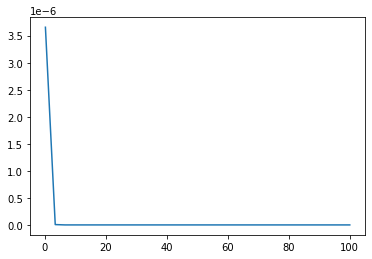

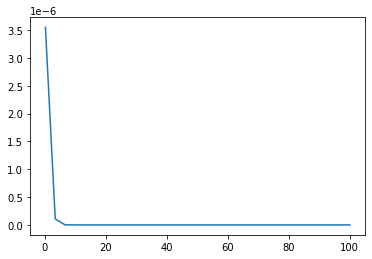

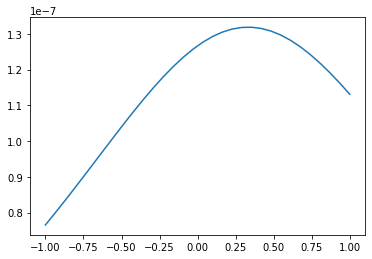

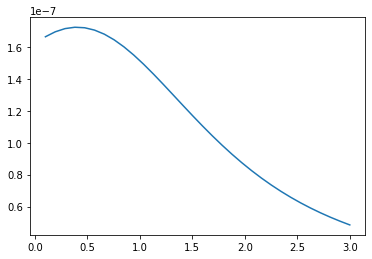

128 72.13119506835938


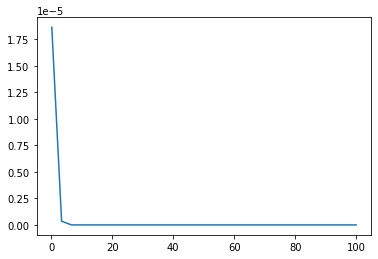

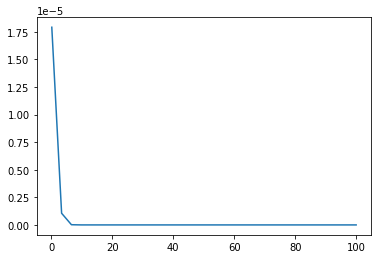

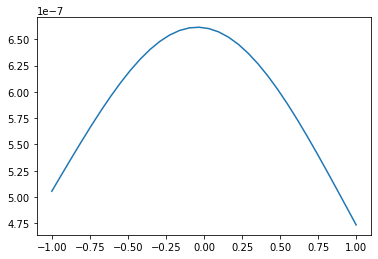

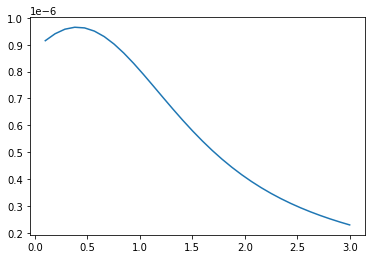

256 56.81822967529297


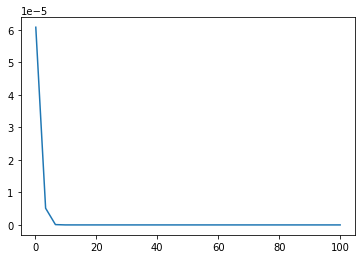

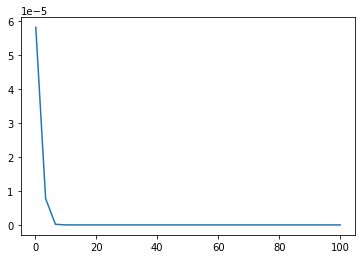

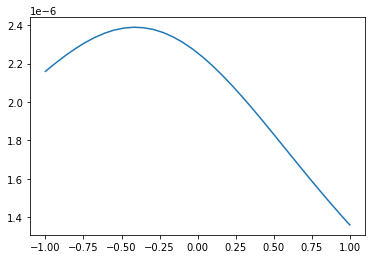

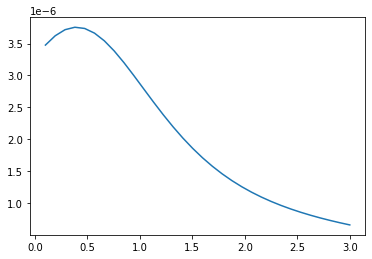

384 48.799015045166016


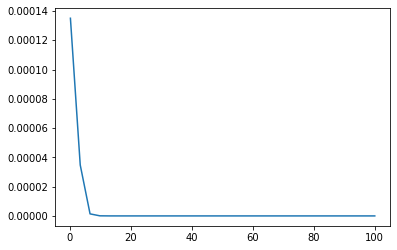

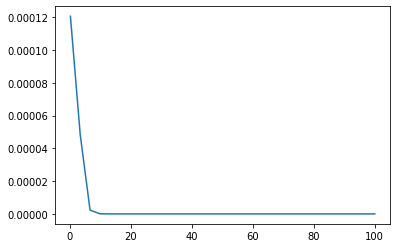

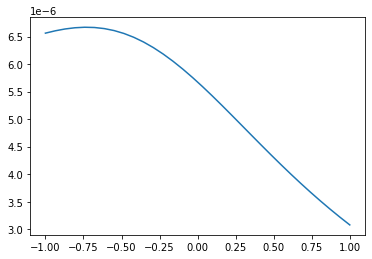

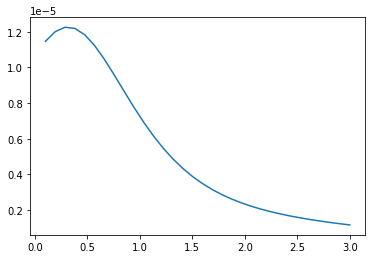

512 42.315555572509766


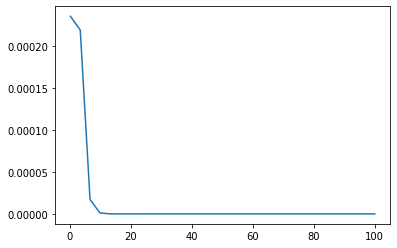

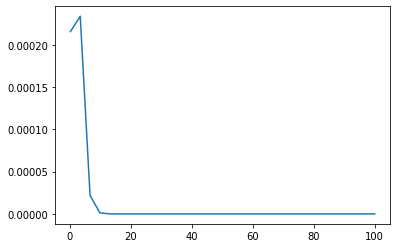

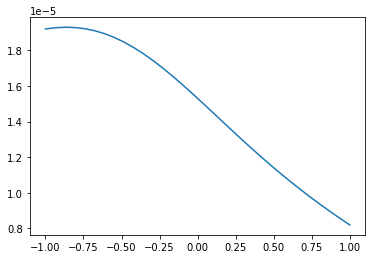

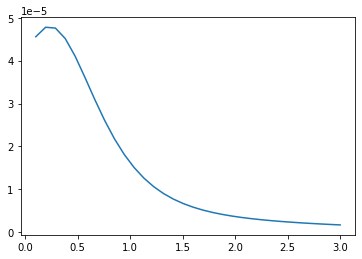

640 33.30112838745117


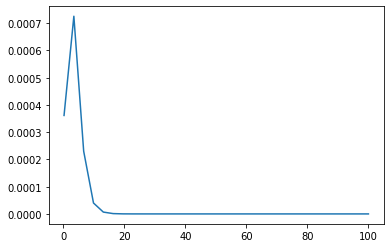

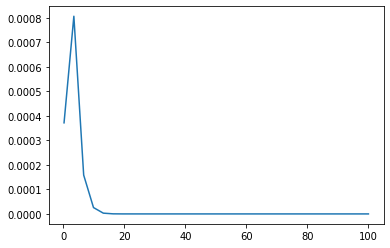

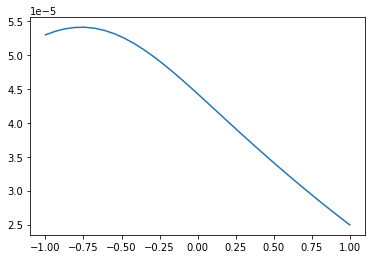

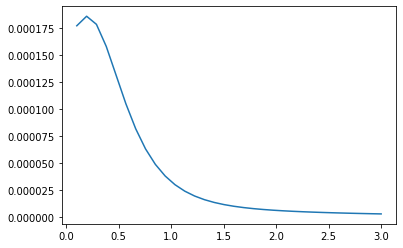

768 28.83209800720215


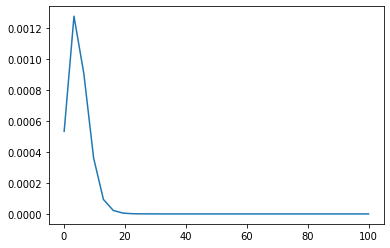

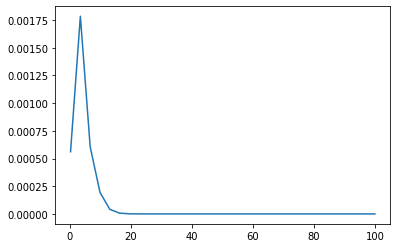

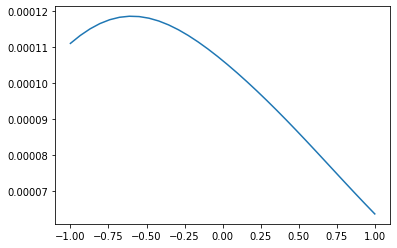

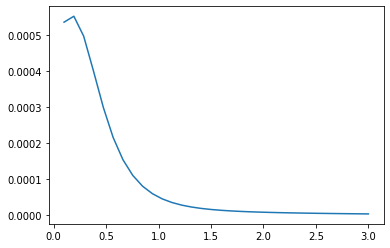

896 25.930997848510742


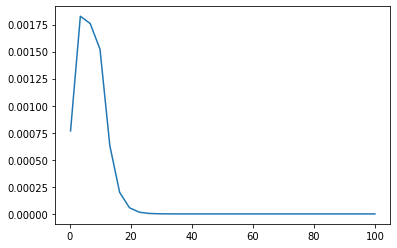

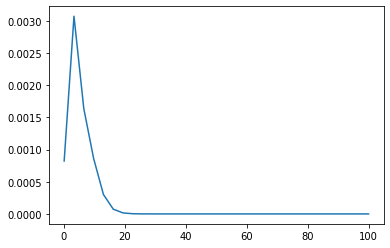

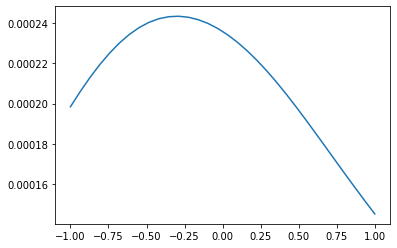

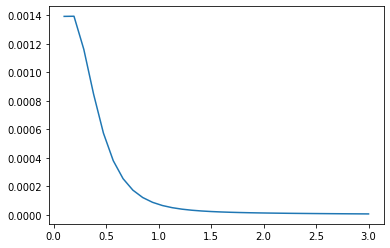

1024 23.750322341918945


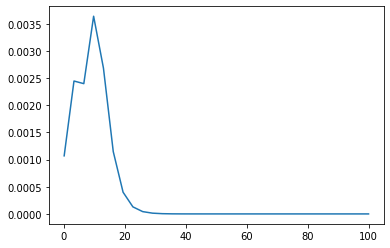

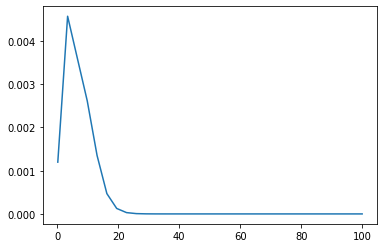

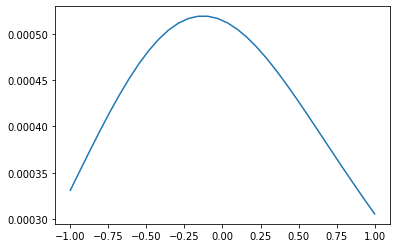

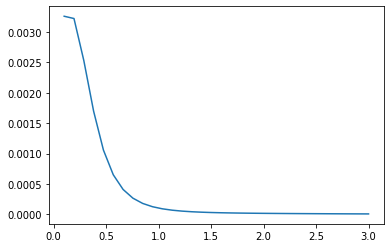

1152 21.380895614624023


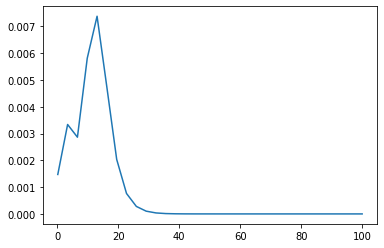

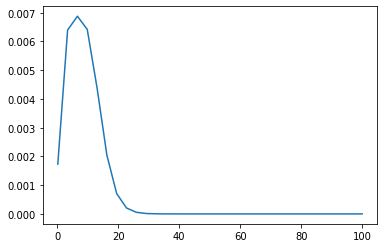

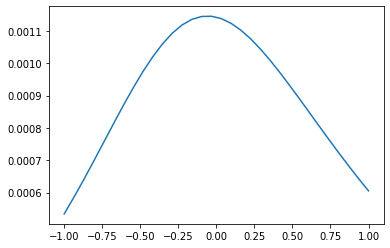

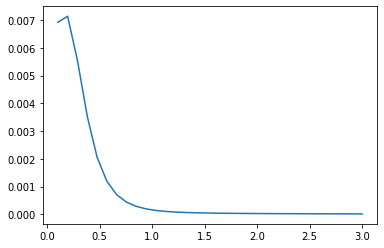

1280 19.45017433166504


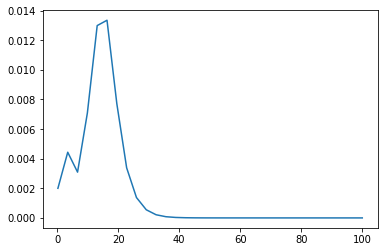

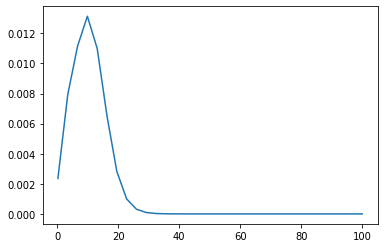

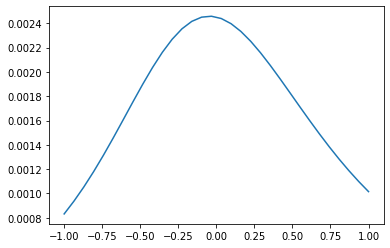

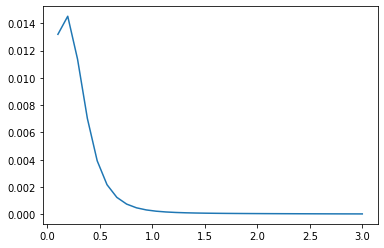

1408 18.048324584960938


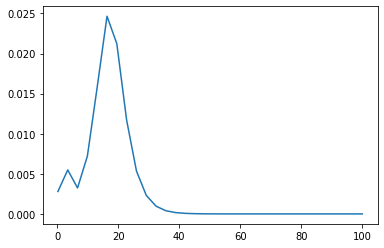

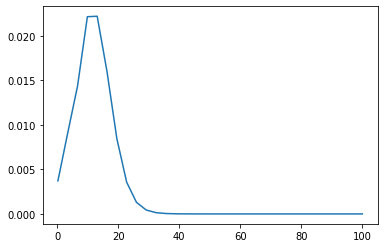

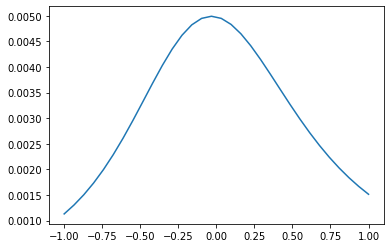

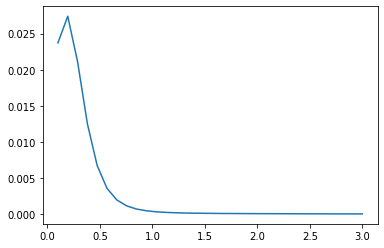

1536 17.08662223815918


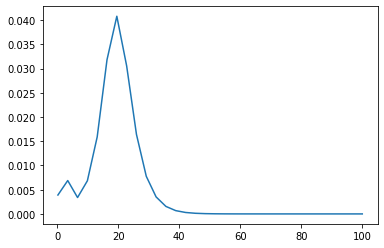

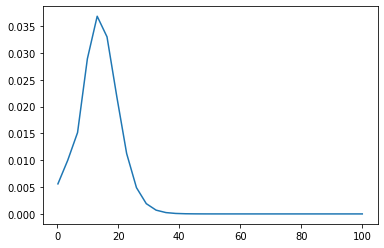

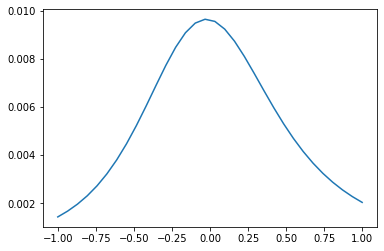

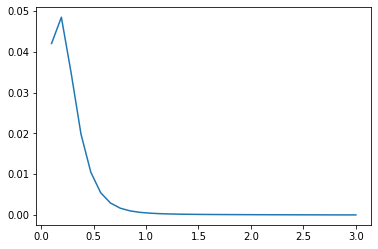

1664 15.803027153015137


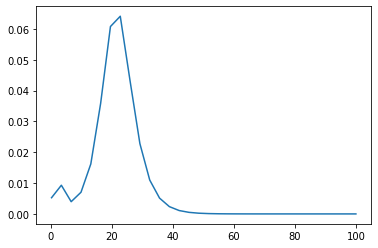

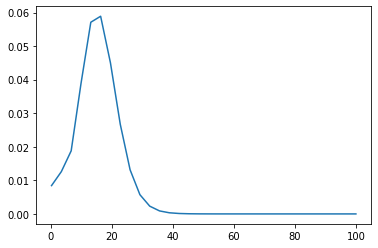

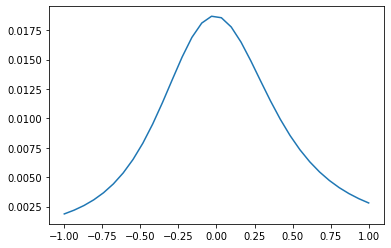

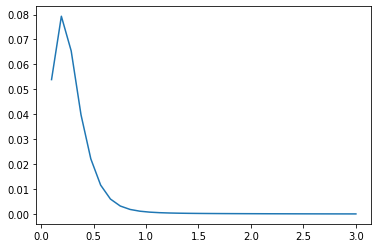

1792 15.175701141357422


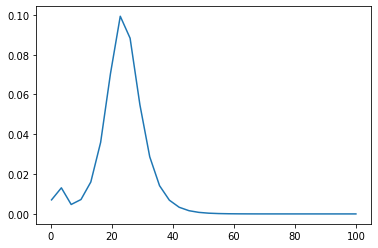

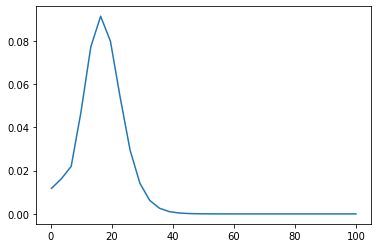

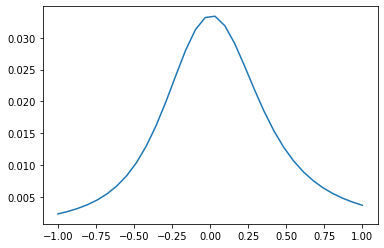

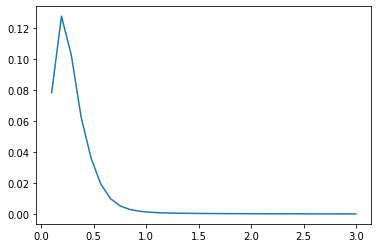

1920 14.283236503601074


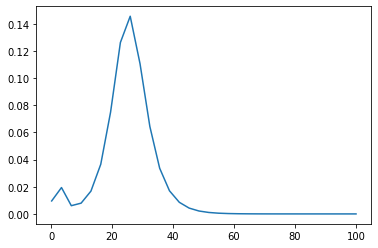

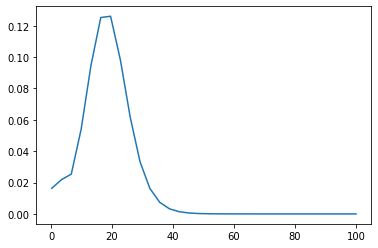

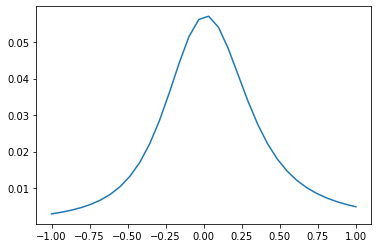

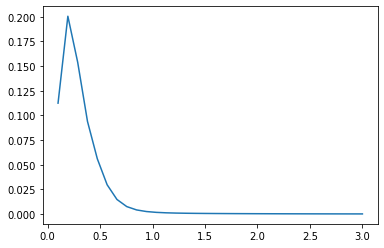

2048 13.6179780960083


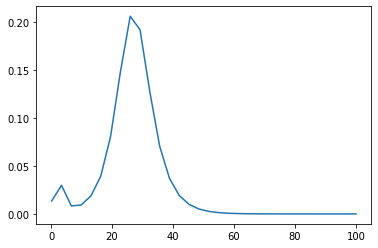

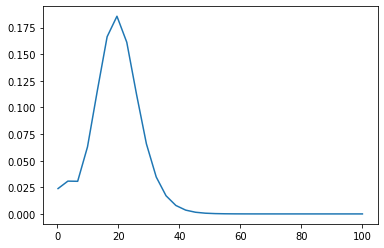

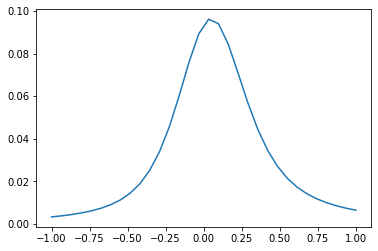

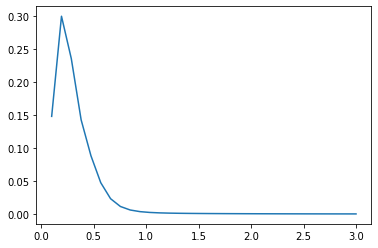

2176 12.934760093688965


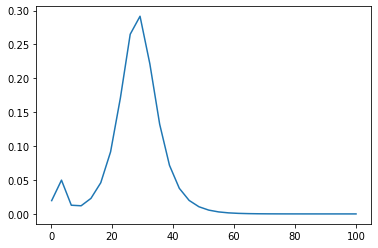

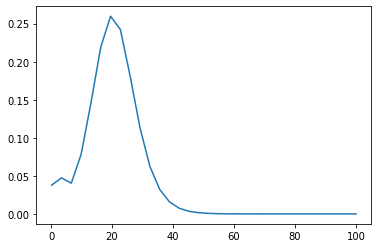

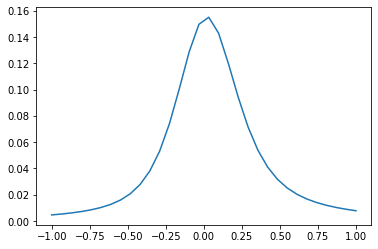

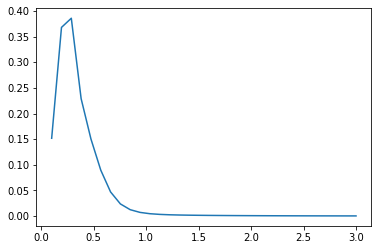

2304 12.102531433105469


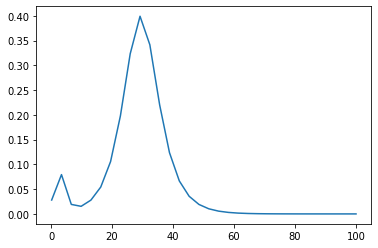

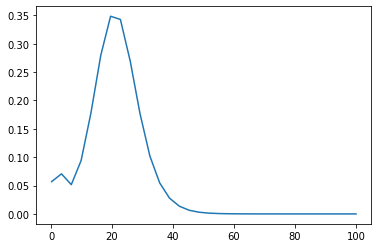

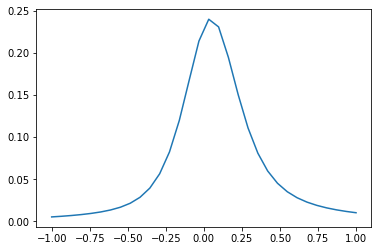

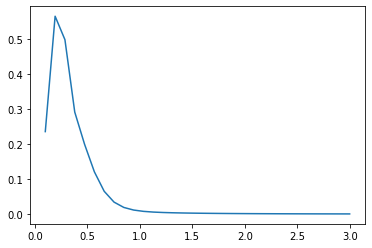

2432 11.95467472076416


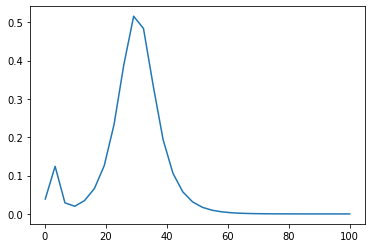

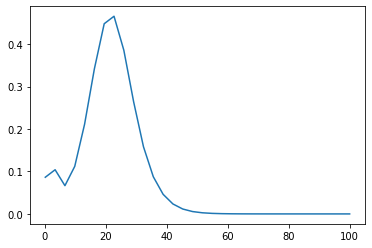

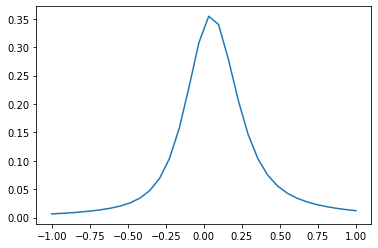

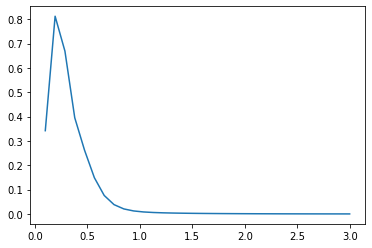

2560 12.03808879852295


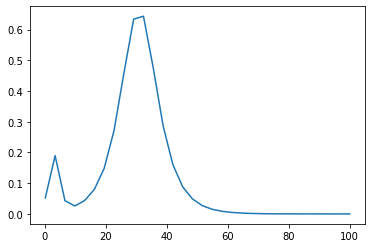

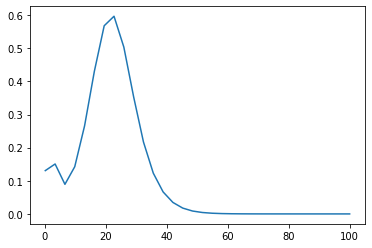

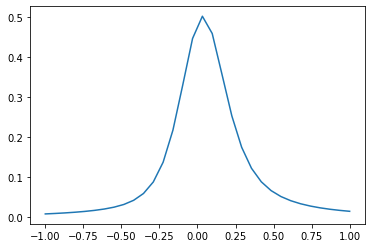

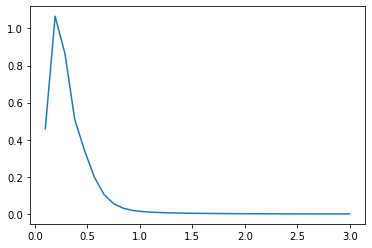

2688 11.211780548095703


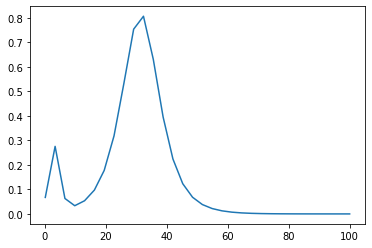

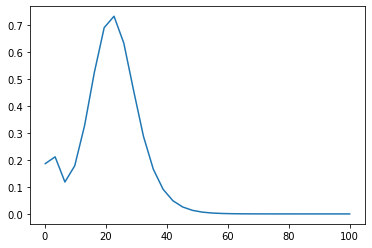

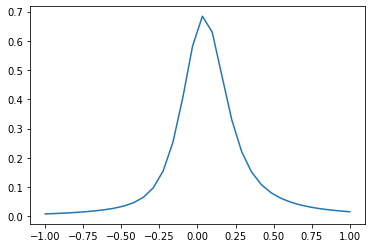

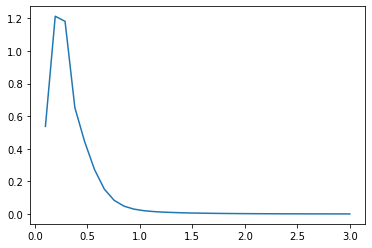

2816 11.337520599365234


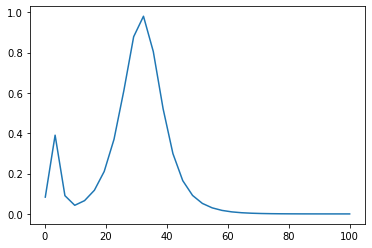

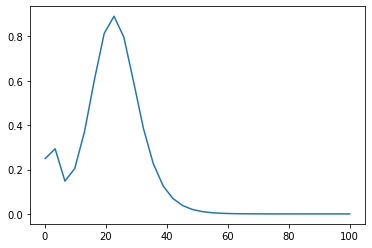

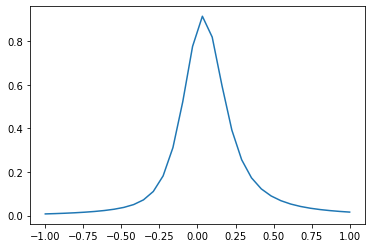

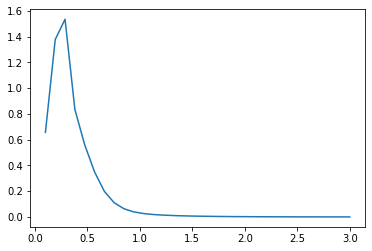

2944 10.876173973083496


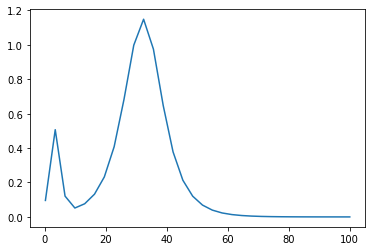

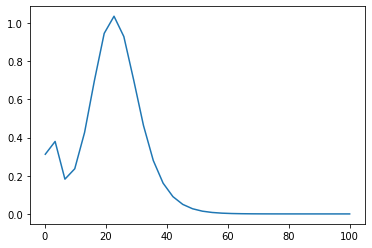

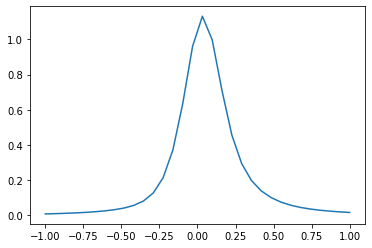

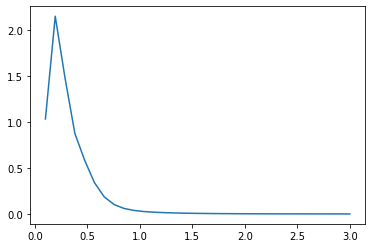

3072 10.794107437133789


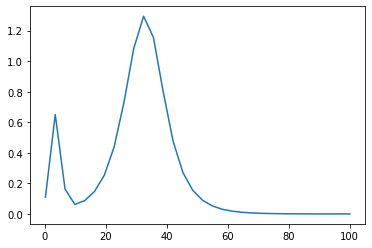

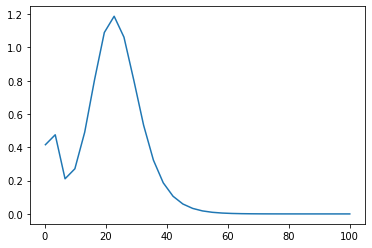

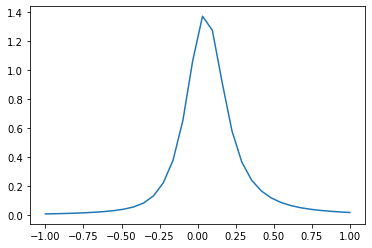

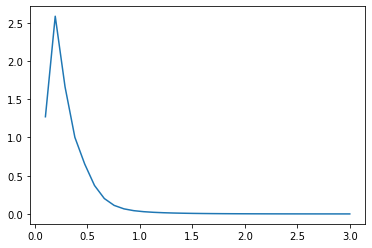

3200 10.551745414733887


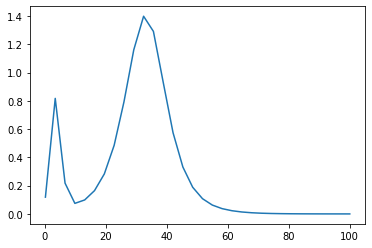

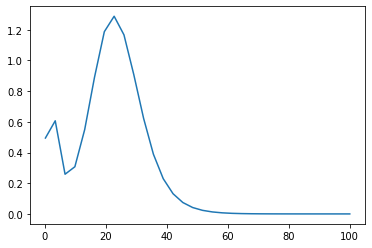

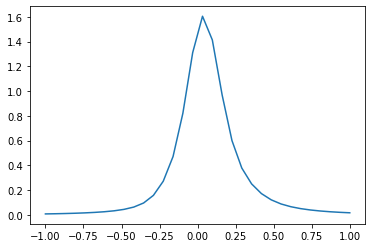

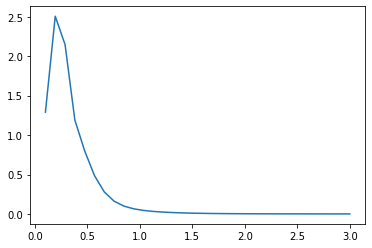

3328 10.482722282409668


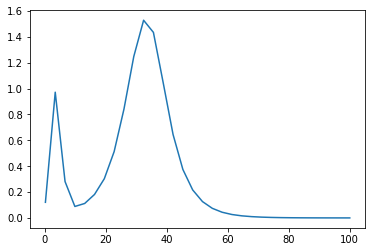

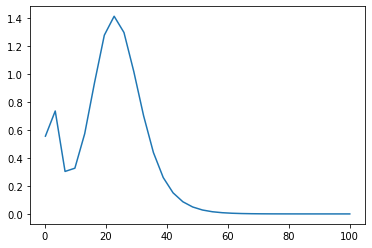

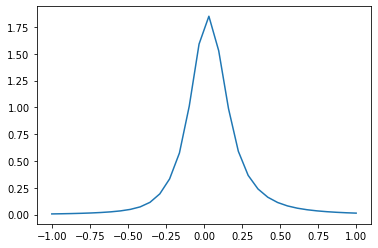

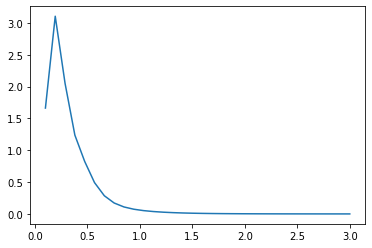

3456 10.108059883117676


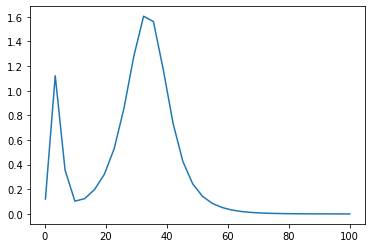

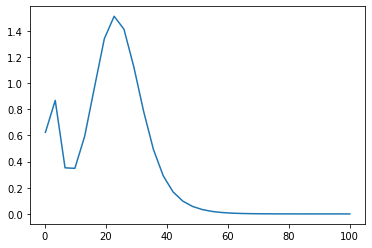

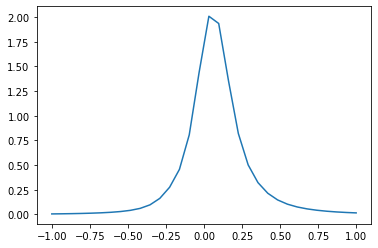

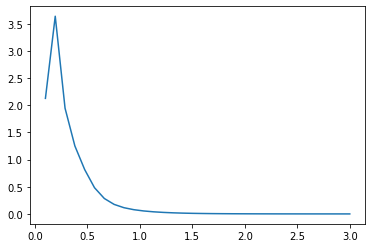

3584 10.120447158813477


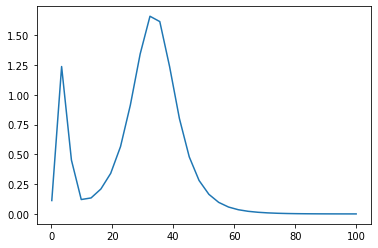

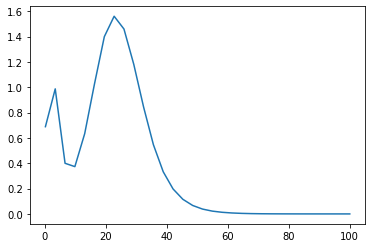

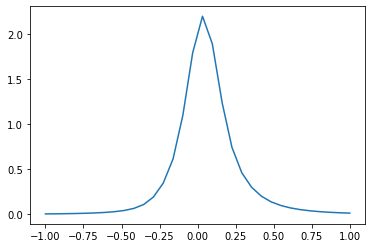

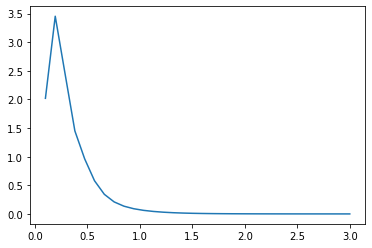

3712 10.215412139892578


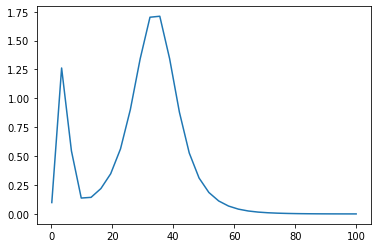

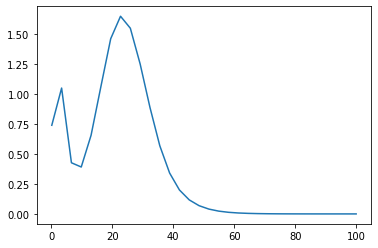

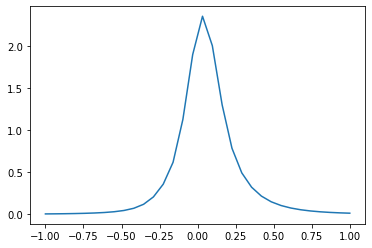

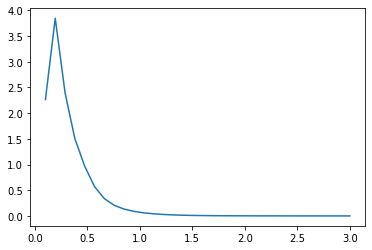

3840 10.023462295532227


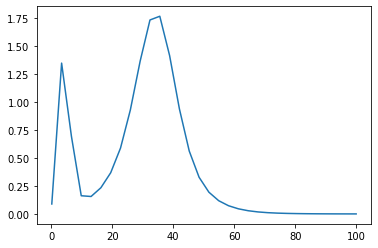

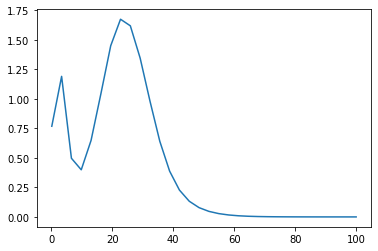

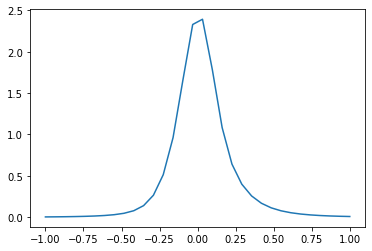

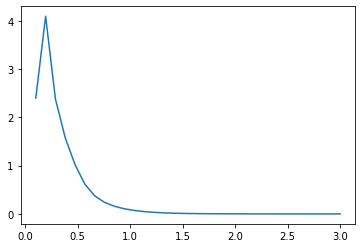

3968 9.816156387329102


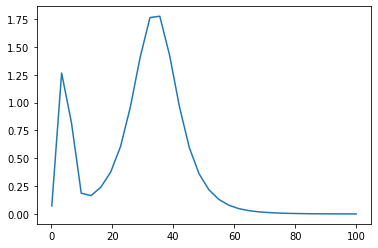

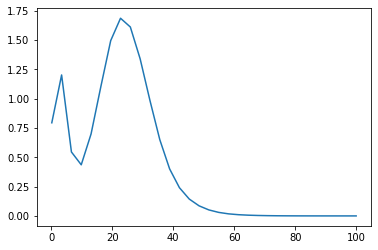

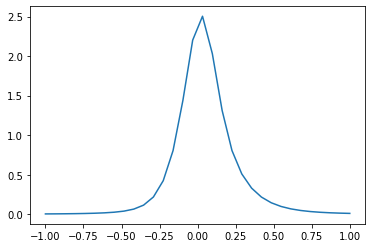

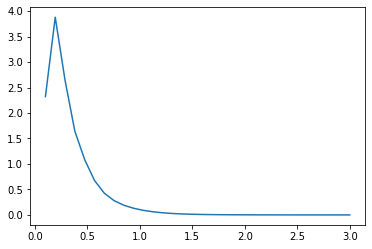

4096 9.652284622192383


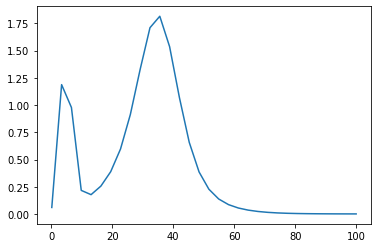

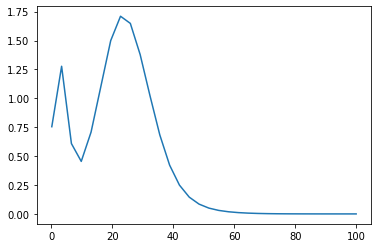

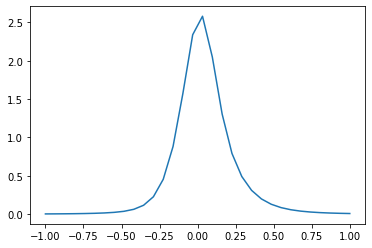

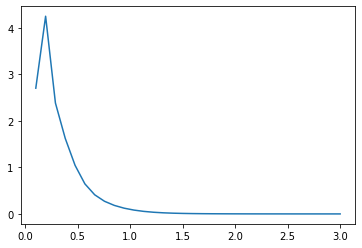

4224 9.832277297973633


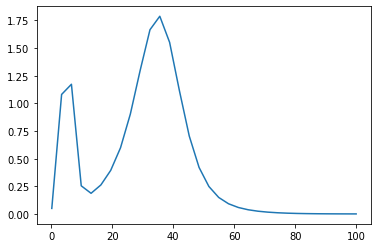

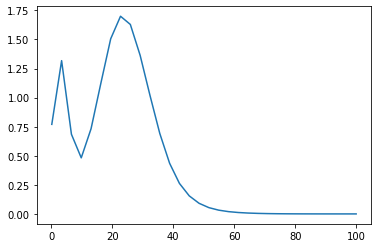

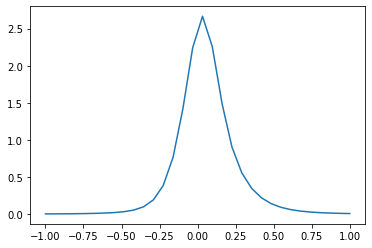

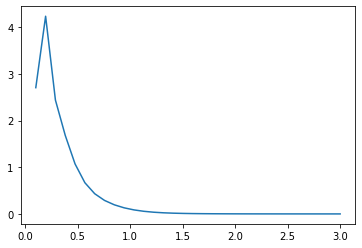

4352 9.682912826538086


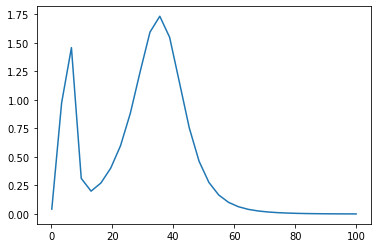

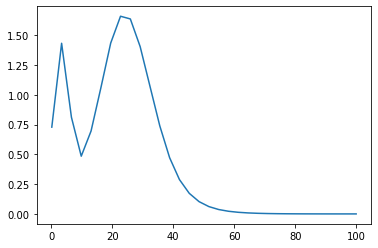

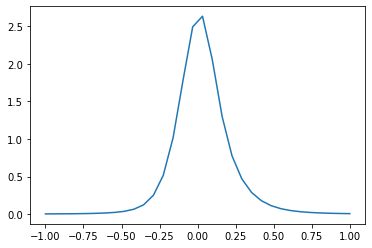

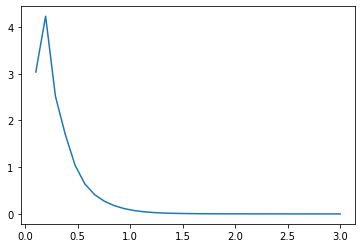

4480 9.844672203063965


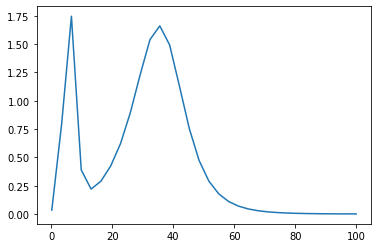

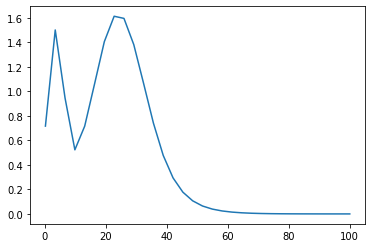

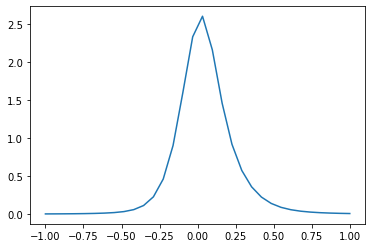

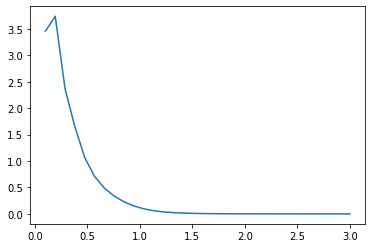

4608 9.600441932678223


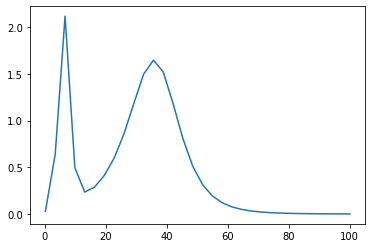

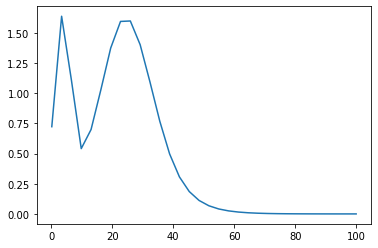

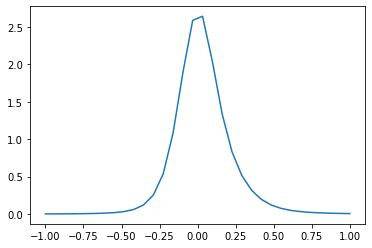

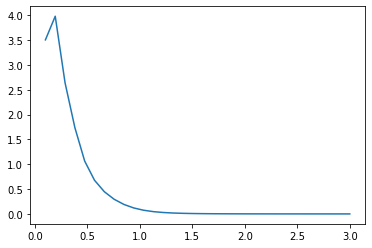

4736 9.438006401062012


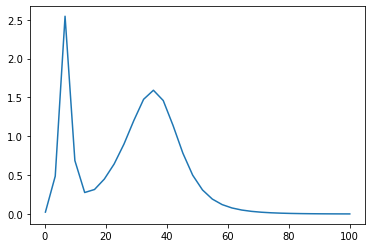

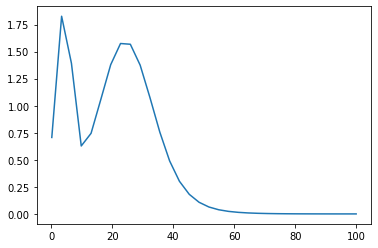

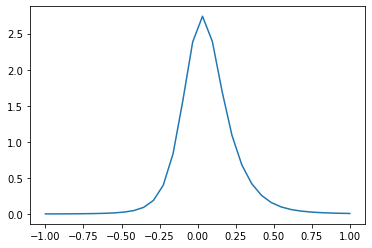

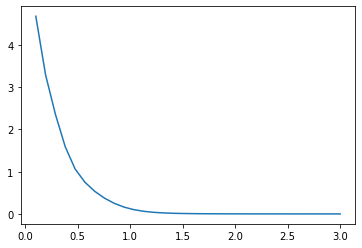

4864 9.49597454071045


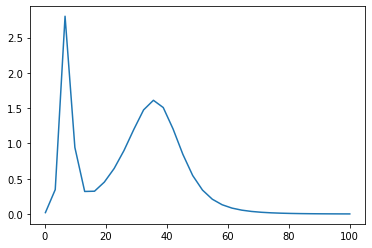

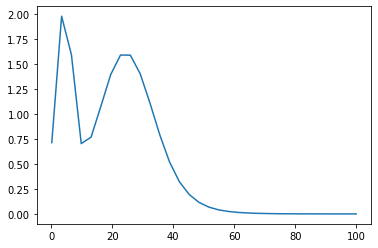

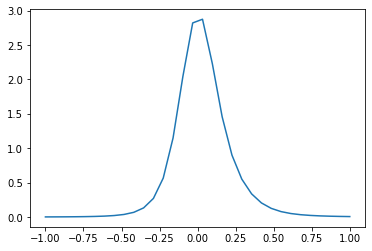

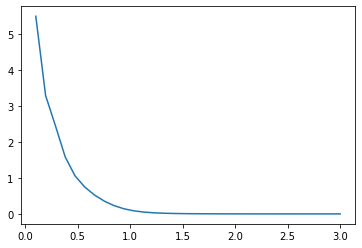

4992 9.319568634033203


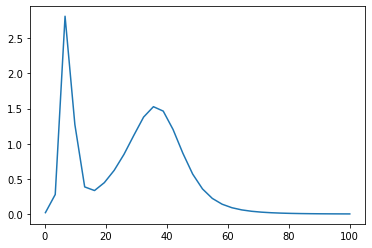

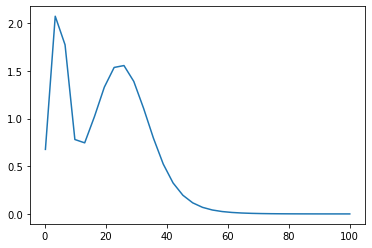

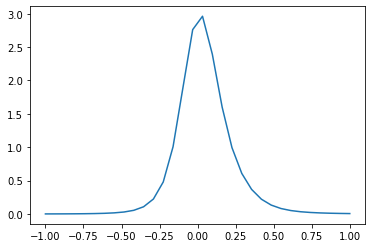

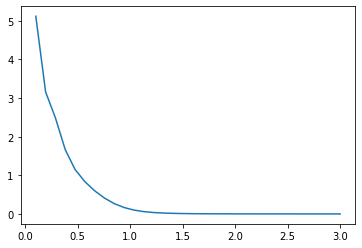

5120 9.149584770202637


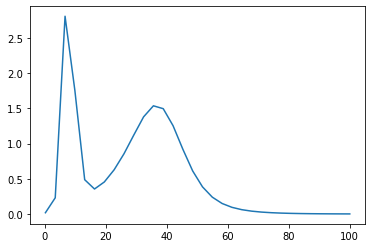

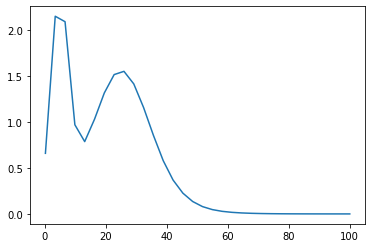

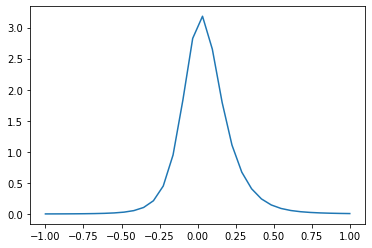

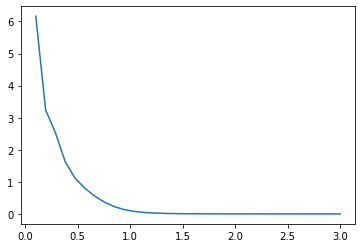

5248 8.977954864501953


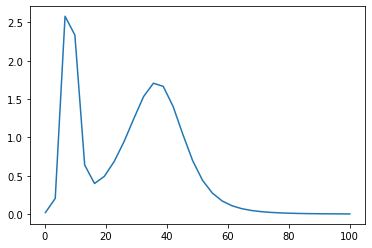

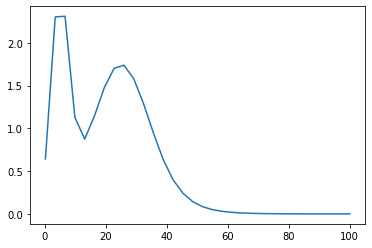

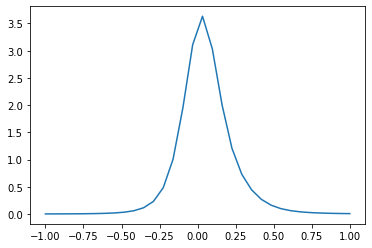

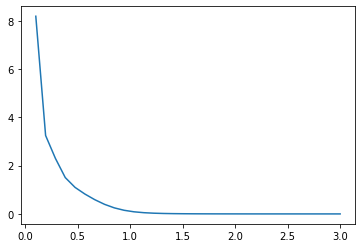

5376 9.070605278015137


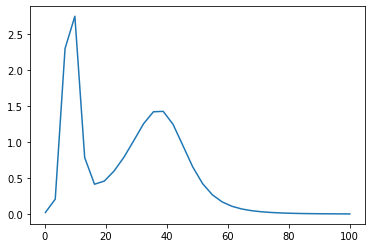

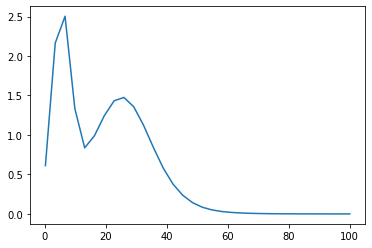

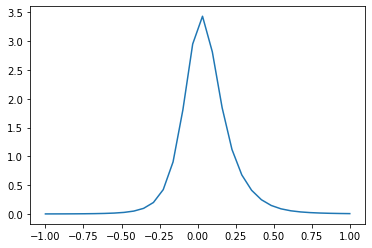

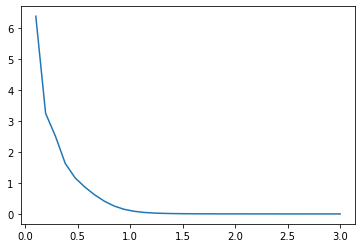

5504 9.124741554260254


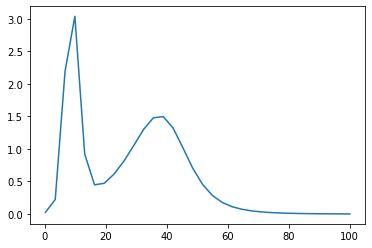

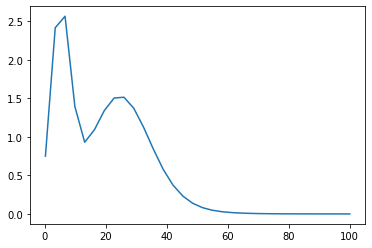

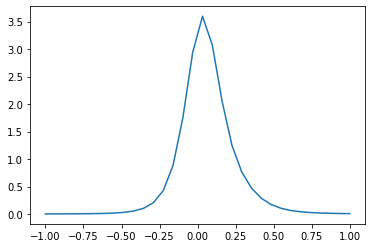

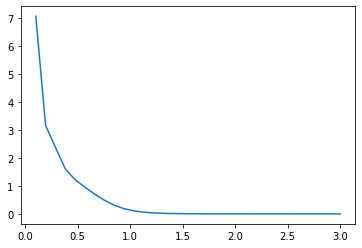

5632 9.151782989501953


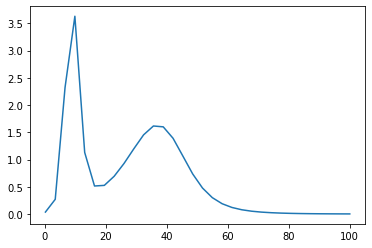

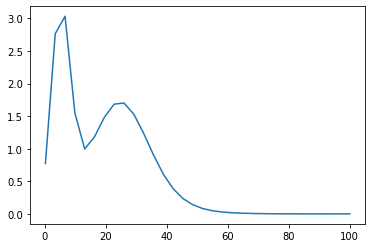

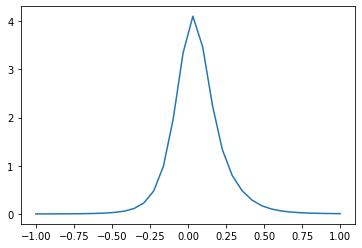

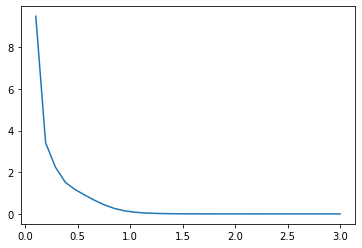

5760 9.293058395385742


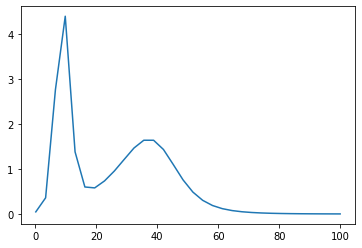

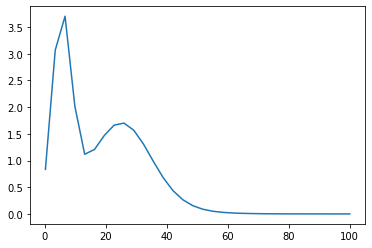

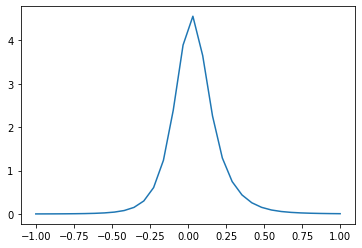

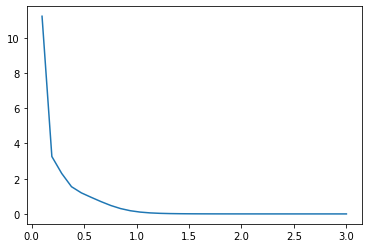

5888 9.165287971496582


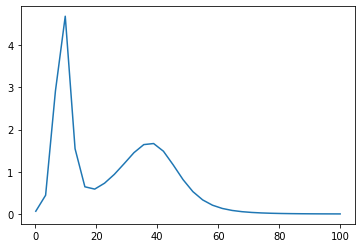

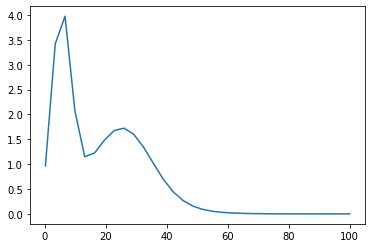

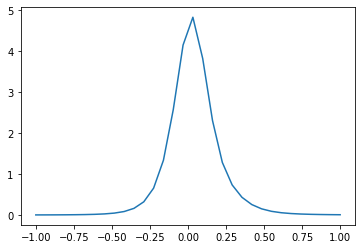

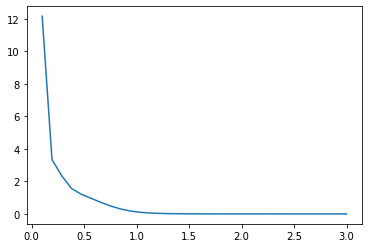

6016 9.013155937194824


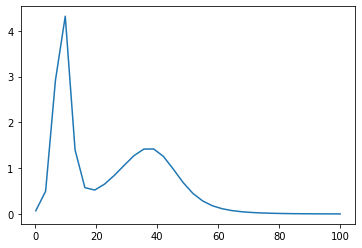

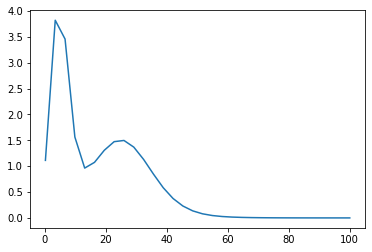

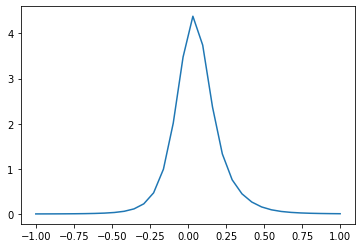

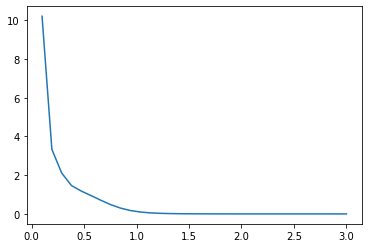

6144 9.06684684753418


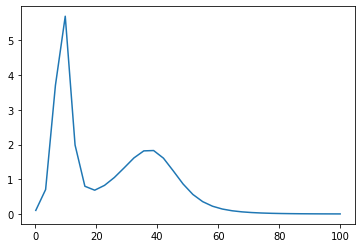

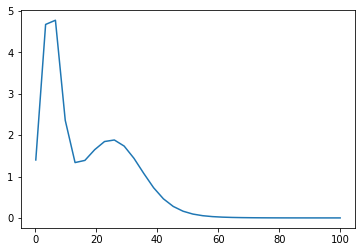

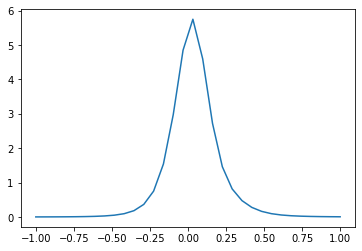

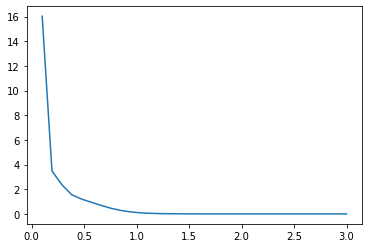

In [14]:
step = 0
steps = 6144
train = True
while train:
    for theta_batch in dataloader:
        optimizer.zero_grad()
        
        theta_batch = theta_batch.to(DEVICE).permute(1, 0, 2)

        z_prior = theta_batch[:, :, 4].clone() / 1e9
        chi_prior = theta_batch[:, :, 5].clone()
        q = torch.tensor(1.0)
        q = q * z_prior
        q = q * chi_prior
        logq = q.log()
        
        
        theta_batch = theta_batch.clone()[:, :, :DIM]
        
        logprob = transformed_dist.log_prob(theta_batch.reshape(-1, DIM)).view(theta_batch.shape[:-1])

        logprob = torch.logsumexp(logprob - logq, dim=1) - math.log(logprob.shape[1])

        logprob = logprob.mean()
        loss = -logprob
        loss.backward()
        optimizer.step()

        for t in transformed_dist.transforms:
            t.clear_cache()

        if step % 128 == 0:
            print(step, loss.item())

            with torch.no_grad():
                prob = transformed_dist.log_prob(grid).exp().view(NX, NX, NX, NX).cpu()

                pm1 = prob.sum((1, 2, 3))
                plt.plot(grid_m1_, pm1)
                plt.show()


                pm2 = prob.sum((0, 2, 3))
                plt.plot(grid_m2_, pm2)
                plt.show()

                pX = prob.sum((0, 1, 3))
                plt.plot(grid_X_, pX)
                plt.show()


                pz = prob.sum((0, 1, 2))
                plt.plot(grid_z_, pz)
                plt.show()

        step += 1
        if step > steps:
            train = False
            break


In [15]:
del prob
prob = transformed_dist.log_prob(grid).exp().view(NX, NX, NX, NX).cpu()


In [16]:
# inv = log_transform(grid_m1)
inv = grid_m1
pm1 = prob.sum((1, 2, 3)).log() # + log_transform.log_abs_det_jacobian(grid_m1, inv)


(-5.0, 5.0)

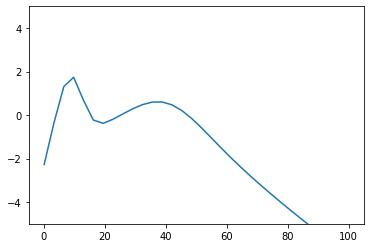

In [17]:
plt.plot(grid_m1, pm1.detach())
plt.ylim(-5, 5)

In [18]:
# inv = logit_transform(grid_q)
pm2 = prob.sum((0, 2, 3)).log() # + logit_transform.log_abs_det_jacobian(grid_q, inv)


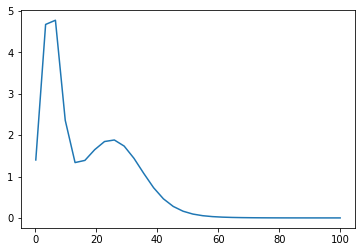

In [19]:
plt.plot(grid_m2, pm2.detach().exp())


In [20]:
pX = prob.sum((0, 1, 3)).log()

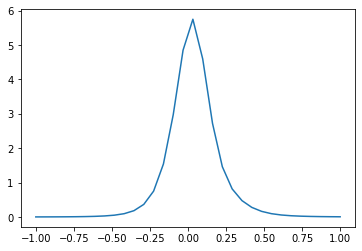

In [21]:
plt.plot(grid_X, pX.detach().exp())


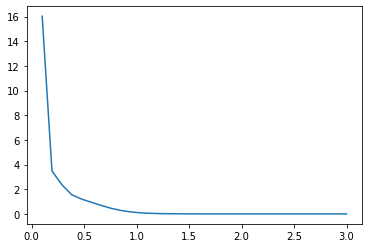

In [22]:
pz = prob.sum((0, 1, 2)).log()
plt.plot(grid_z, pz.detach().exp())


# Sample The Model

In [23]:
rng = (grid_m1_.min(), grid_m1_.max()), (grid_m2_.min(), grid_m2_.max()), (grid_X_.min(), grid_X_.max()), (grid_z_.min(), grid_z_.max())





In [24]:
torch.FloatTensor(rng)

tensor([[  0.2000, 100.0000],
        [  0.2000, 100.0000],
        [ -1.0000,   1.0000],
        [  0.1000,   3.0000]])

In [25]:
@torch.no_grad()
def rejection_sampling(fn, rng, num_samples=1024, batch_size=32768, max_log_prob=0, n_dims=1):
    z = torch.tensor([], device=DEVICE)
    i = 0
    rng = torch.FloatTensor(rng)
    max = rng[:, 1]
    min = rng[:, 0]
    while len(z) < num_samples:
        eps = torch.rand((num_samples, n_dims))
        
        z_ = eps * (max - min) + min
        prob = torch.rand(num_samples, device=DEVICE)
        z_ = z_.to(DEVICE)
        logprob = fn(z_).squeeze()
        assert not torch.any(logprob > max_log_prob), (logprob.max(), max_log_prob)
        prob_ = torch.exp(logprob - max_log_prob)
        
        accept = prob_ > prob
        z = torch.cat([z, z_[accept, :]])
        i += 1
        print(len(z))
    return z[:num_samples]

In [26]:
samples = rejection_sampling(transformed_dist.log_prob, rng, n_dims=4).cpu()

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6


<AxesSubplot:ylabel='Density'>

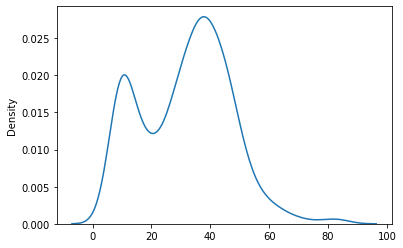

In [27]:
sns.kdeplot(samples[:, 0])

<AxesSubplot:ylabel='Density'>

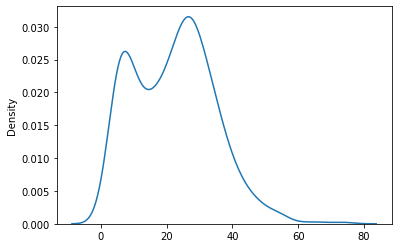

In [28]:
sns.kdeplot(samples[:, 1])

<AxesSubplot:ylabel='Density'>

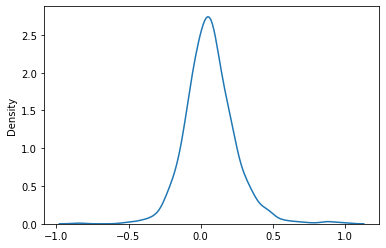

In [29]:
sns.kdeplot(samples[:, 2])

<AxesSubplot:ylabel='Density'>

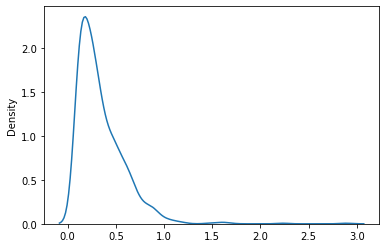

In [30]:
sns.kdeplot(samples[:, 3])

In [31]:
samples[:, 1] = samples[:, 1] / samples[:, 0]

In [32]:
samples = samples[samples[:, 1] <= 1]

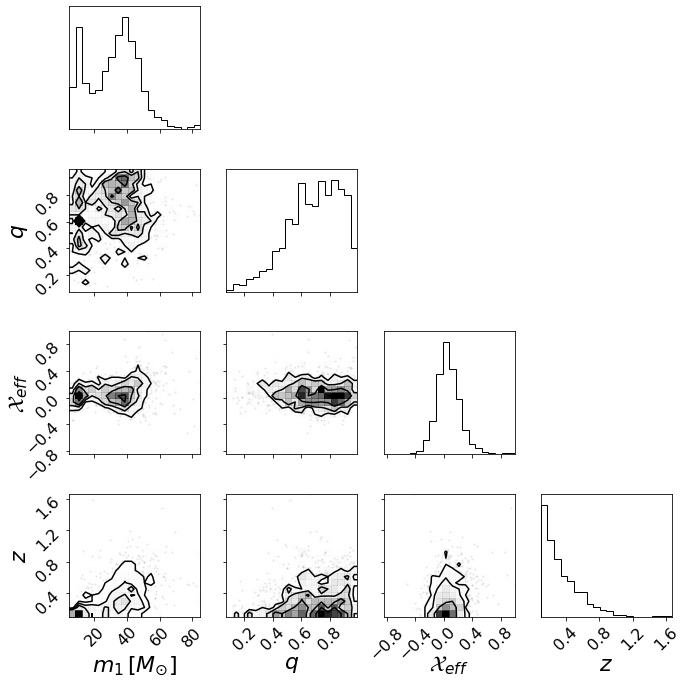

In [33]:
import corner
fig = corner.corner(samples.numpy(), labels=[r"$m_1\, [M_{\odot}]$", r"$q$", r"$\mathcal{X}_{eff}$", r"$z$"], label_kwargs=dict(fontsize=22))

for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=16)
plt.tight_layout()

# fig.subplots_adjust(right=1.5,top=1.5)
plt.savefig('corner.pdf', bbox_inches='tight')



